# Laplacian Associative Memory (LAM) - SIGMA

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import sys
sys.path.append('..')

In [2]:
import PIL.Image, imageio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from nn_npy import LAM
import libtools

---

#### DATA

In [4]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)
# img = libtools.downsample(img, 2) # Downsample
img = img[:100,:100] # Crop
img /= np.max(img)

print('Image:', img.shape)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: (100, 100)
min: 0.02 max: 1.00


---

In [5]:
f = np.fft.fft2(img) # Frequency transform
fshift = np.fft.fftshift(f) # Shift zero frequency component (DC-component)
power = np.abs(fshift) # Process complex numbers
phase = np.angle(fshift)

In [6]:
# Define radial distance
nx, ny = power.shape
x = np.arange(-power.shape[0]//2, power.shape[0]//2)
y = np.arange(-power.shape[1]//2, power.shape[1]//2)
X, Y = np.meshgrid(x, y)
dist = np.sqrt(X**2 + Y**2)

# Compute spatial frequency
hist, bins = np.histogram(dist.flatten(), bins=np.arange(dist.max()), weights=power.flatten())

count = hist[1:].argmax()
print('Freqency at which power is greatest:', count)

Freqency at which power is greatest: 12


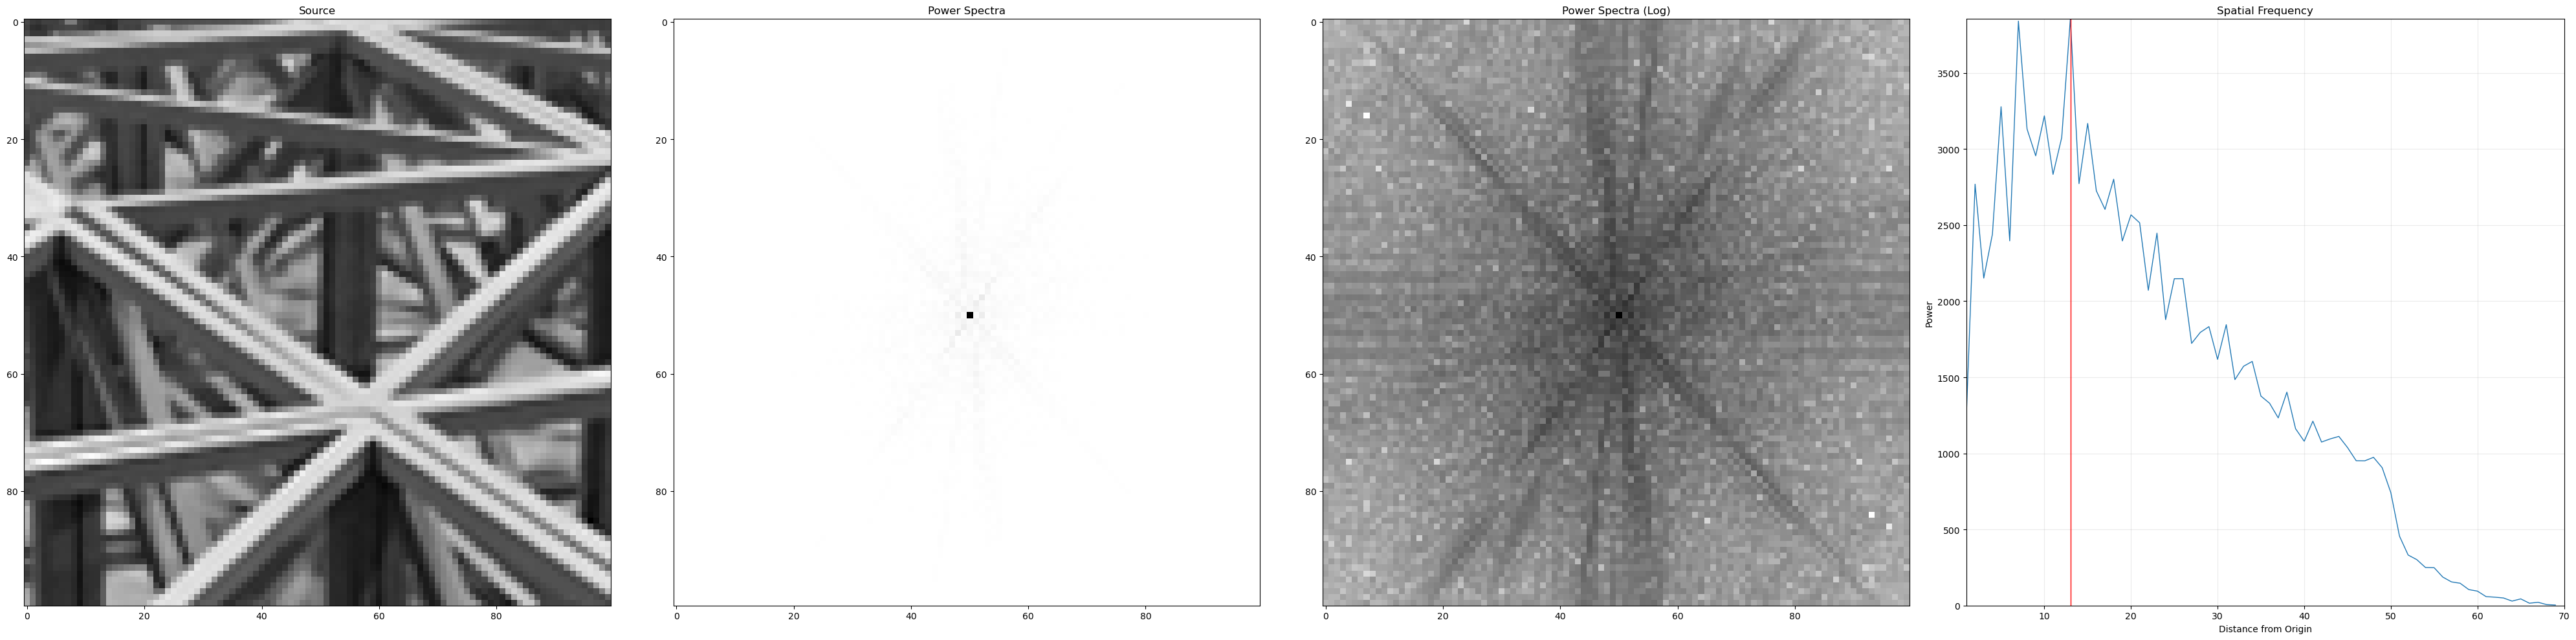

In [7]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(img, 'gray')
plt.title('Source')

plt.subplot(1,4,2)
plt.imshow(power, 'binary')
plt.title('Power Spectra')

plt.subplot(1,4,3)
plt.imshow(np.log(power), 'binary')
plt.title('Power Spectra (Log)')

plt.subplot(1,4,4)
plt.plot(bins[:-1], hist, lw=1)
plt.vlines(count+1, 0, hist[1:].max(), linewidth=1, color='r')
plt.title('Spatial Frequency')
plt.xlabel('Distance from Origin'), plt.ylabel('Power')
plt.xlim([1,int(dist.max())]), plt.ylim([0,int(hist[1:].max())])
plt.grid(alpha=0.25)
plt.tight_layout()

---

In [8]:
src = libtools.preference_map(16, count*2, img.shape[0]) # x2 power of spatial frequency FFT
# np.save('../data/mat/SOM_orient_v2.npy', src)
# src = np.load('../data/mat/SOM_orient_v2.npy')

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (100, 100)
min: 0.00 max: 6.28


In [9]:
features = libtools.gabor_conv(img, src, step=int(count)) # Power of spatial frequency FFT (No multiplicative factor)
features /= np.max(features)

print('Features:', features.shape)
print('min:', f"{features.min():.2f}", 'max:', f"{features.max():.2f}")

Features: (100, 100)
min: 0.00 max: 1.00


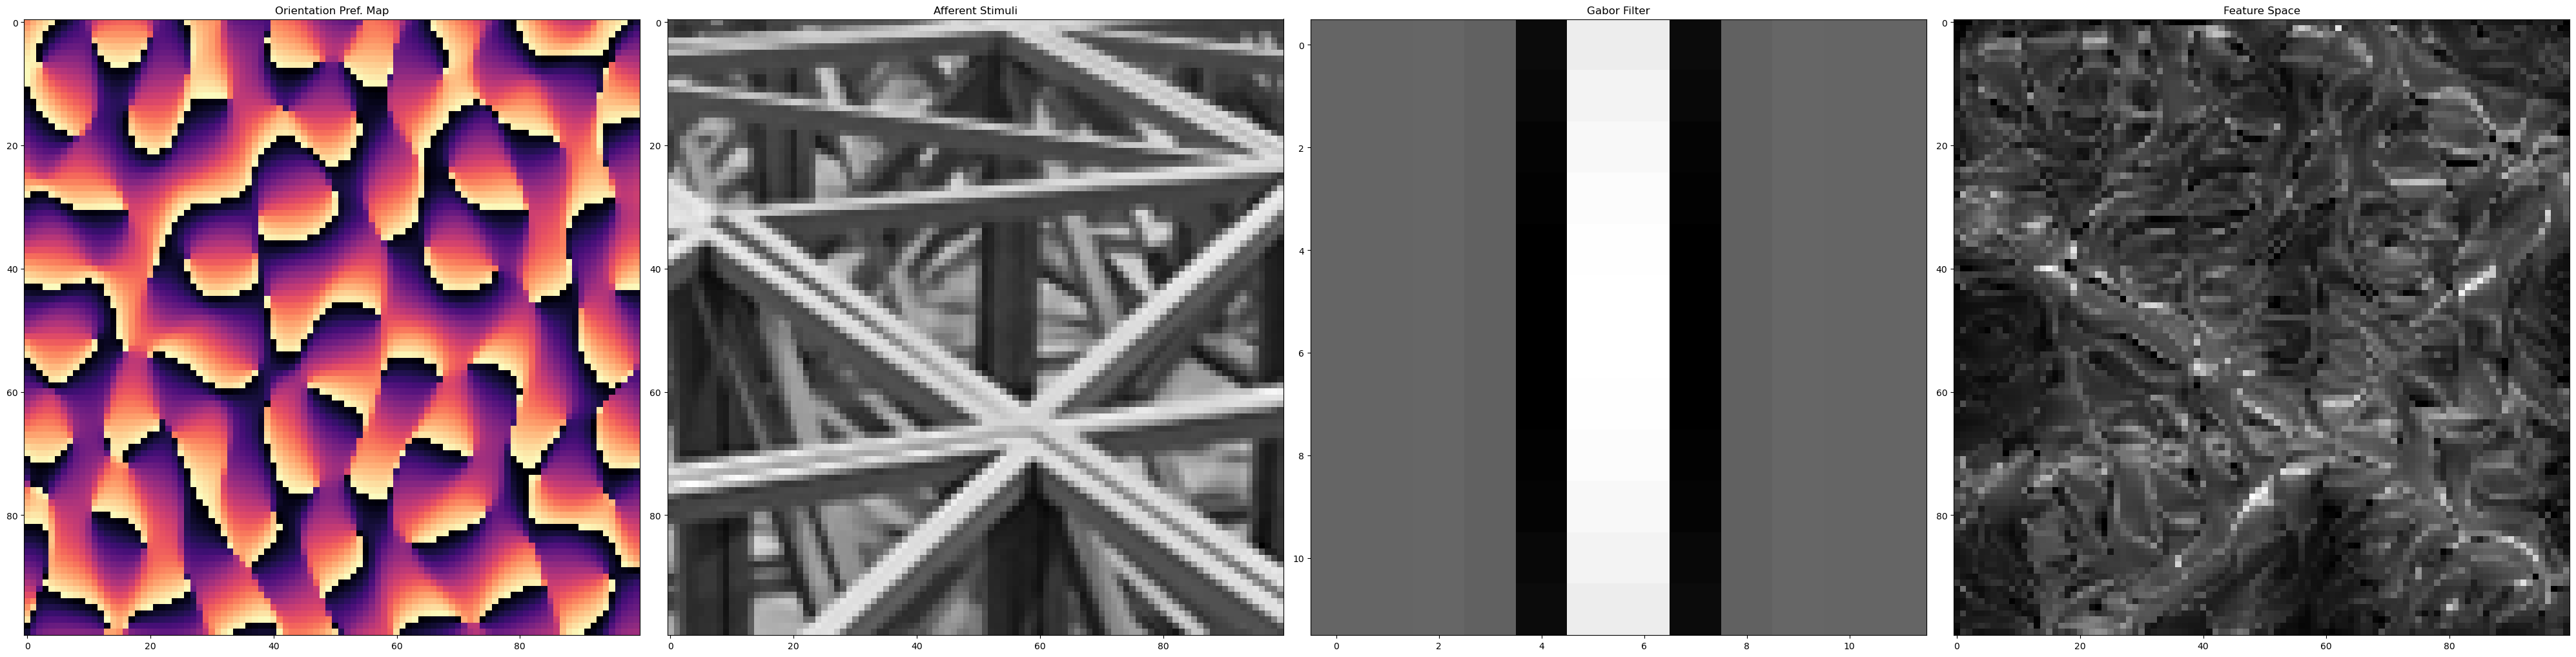

In [10]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(1,4,2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(1,4,3)
plt.imshow(libtools.gabor_filter(1,10,0, samples=int(count)), 'gray')
plt.title('Gabor Filter')

plt.subplot(1,4,4)
plt.imshow(features, 'gray')
plt.title('Feature Space')
plt.tight_layout()

---

### HYPER-PARAMETERS

In [11]:
N = 128**2                              # Units | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
alpha = -0.9                            # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]         # N Nodes

temp = 0.0925                           # Boltzman activation

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Nodes:', N)
print("Neurons:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Nodes: 16384
Neurons: 10000
Start node: 5050
1380.00 point attactors


---

### COMPUTE | SPATIAL (SIGMA_X)

In [12]:
sigmaX = np.array([1e-3, 1e-4, 1e-5, 1e-6]).astype(float)
sigmaA = 0.1

In [13]:
Wx, Mx = [],[]
ticker = len(sigmaX)

for i in tqdm(range(ticker)):
    W = libtools.construct_SLAM(src, sigmaX[i], sigmaA)

    graph = LAM(N, P, prob, W, gamma, "asym")

    init_state = libtools.set_state(graph, features, temp)
    print("Sparsity:", np.sum(init_state/np.size(init_state)))  
    
    m_log, _, _ = graph.simulate_single(alpha, eta, simlen, start_node, init_state.copy())
    m = m_log[-1,:].copy()
    # m[start_node] = np.mean(np.delete(m, start_node))

    Wx.append(W)
    Mx.append(m)

  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 0.10443115234375
Using feature-based initial condition


 25%|██▌       | 1/4 [13:26<40:19, 806.38s/it]

Sparsity: 0.0994873046875
Using feature-based initial condition


 50%|█████     | 2/4 [27:38<27:46, 833.05s/it]

Sparsity: 0.10284423828125
Using feature-based initial condition


 75%|███████▌  | 3/4 [42:15<14:13, 853.18s/it]

Sparsity: 0.09893798828125
Using feature-based initial condition


100%|██████████| 4/4 [56:30<00:00, 847.71s/it]


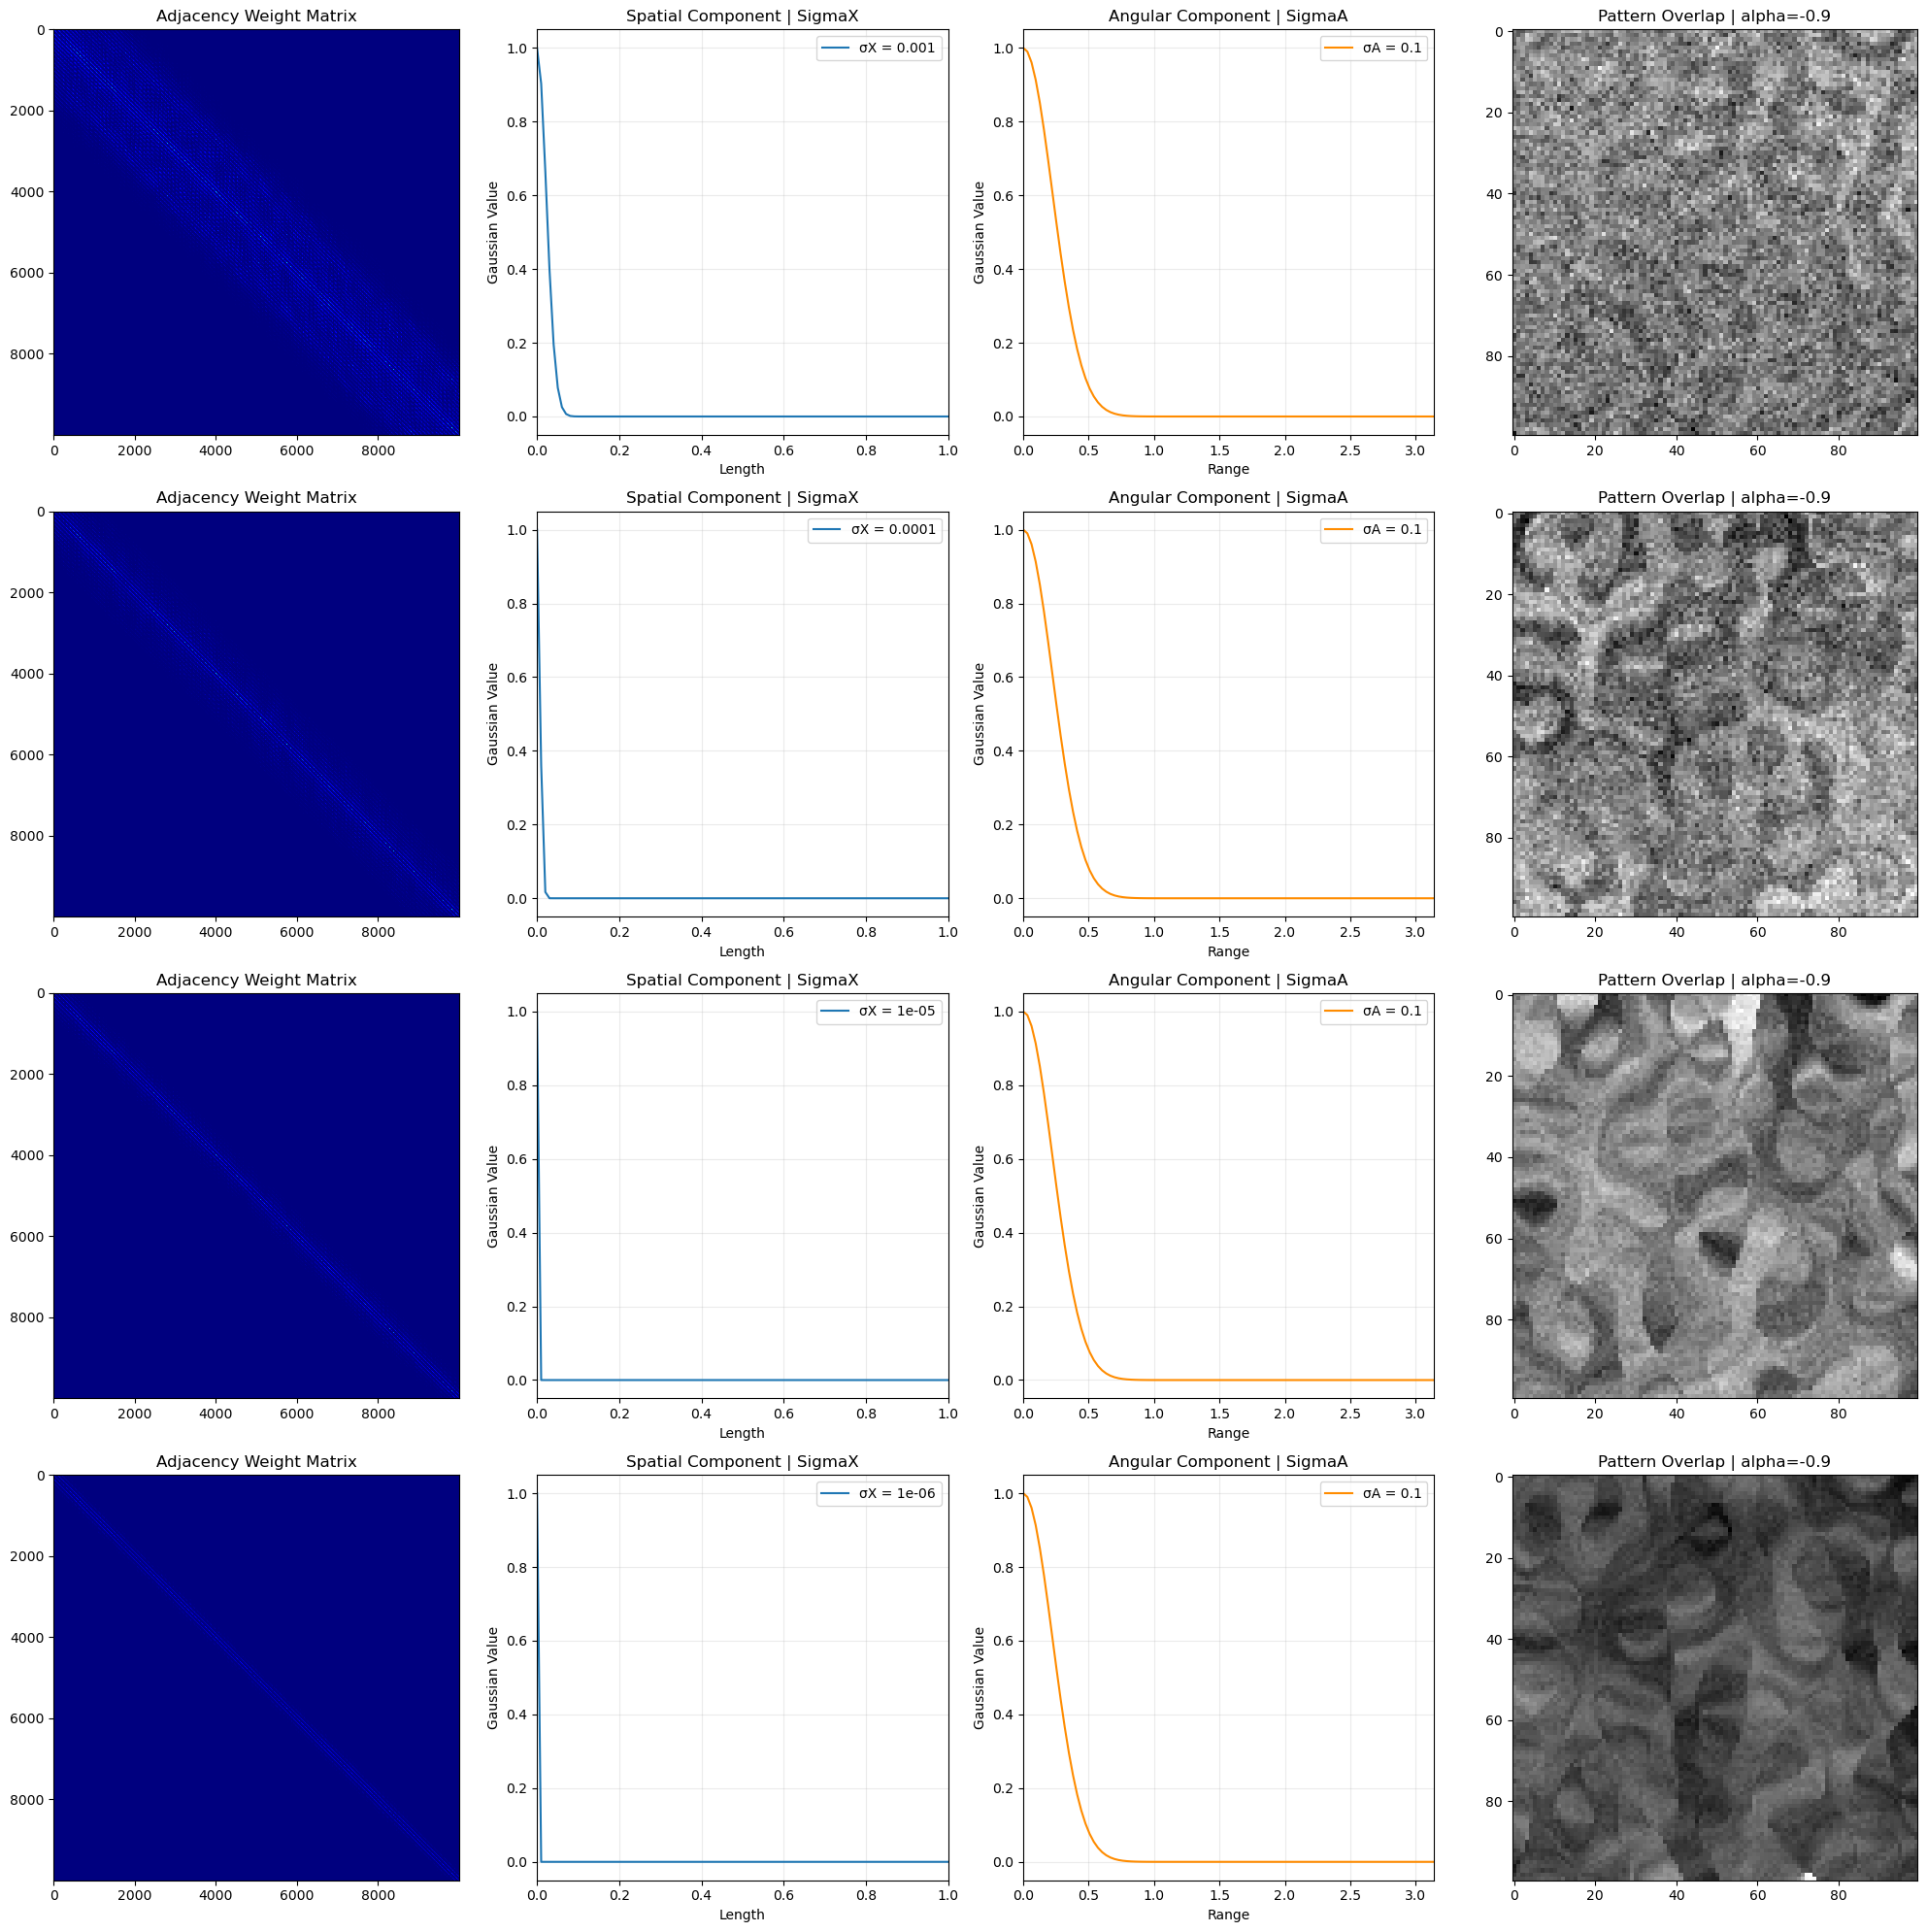

In [14]:
plt.figure(figsize=(20,20))
for i in range(ticker):
    plt.subplot(ticker, 4, i * 4 + 1)
    plt.imshow(Wx[i], 'jet')
    plt.title('Adjacency Weight Matrix')

    plt.subplot(ticker, 4, i * 4 + 2)
    dist_s = np.linspace(0, 1, 100)
    plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX[i]), label=f'σX = {sigmaX[i]}')
    plt.title('Spatial Component | SigmaX')
    plt.xlabel('Length'), plt.ylabel('Gaussian Value')
    plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 4, i * 4 + 3)
    dist_a = np.linspace(0, np.pi, 100)
    plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
    plt.title('Angular Component | SigmaA')
    plt.xlabel('Range'), plt.ylabel('Gaussian Value')
    plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 4, i * 4 + 4)
    plt.imshow(Mx[i].reshape(src.shape), 'gray')
    plt.title('Pattern Overlap | alpha=' + str(alpha))

plt.tight_layout()

---

### COMPUTE | ORIENTATION (SIGMA_A)

In [15]:
sigmaX = 1e-5
sigmaA = np.array([0.1, 0.5, 1.0, 2.0]).astype(float)

In [16]:
Wa, Ma = [],[]
ticker = len(sigmaA)

for i in tqdm(range(ticker)):
    W = libtools.construct_SLAM(src, sigmaX, sigmaA[i])

    graph = LAM(N, P, prob, W, gamma, "asym")

    init_state = libtools.set_state(graph, features, temp)
    print("Sparsity:", np.sum(init_state/np.size(init_state)))  
    
    m_log, _, _ = graph.simulate_single(alpha, eta, simlen, start_node, init_state.copy())
    m = m_log[-1,:].copy()
    # m[start_node] = np.mean(np.delete(m, start_node))

    Wa.append(W)
    Ma.append(m)

  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 0.0989990234375
Using feature-based initial condition


 25%|██▌       | 1/4 [14:26<43:19, 866.38s/it]

Sparsity: 0.10186767578125
Using feature-based initial condition


 50%|█████     | 2/4 [28:04<27:56, 838.11s/it]

Sparsity: 0.0965576171875
Using feature-based initial condition


 75%|███████▌  | 3/4 [41:44<13:49, 829.70s/it]

Sparsity: 0.101806640625
Using feature-based initial condition


100%|██████████| 4/4 [55:47<00:00, 836.92s/it]


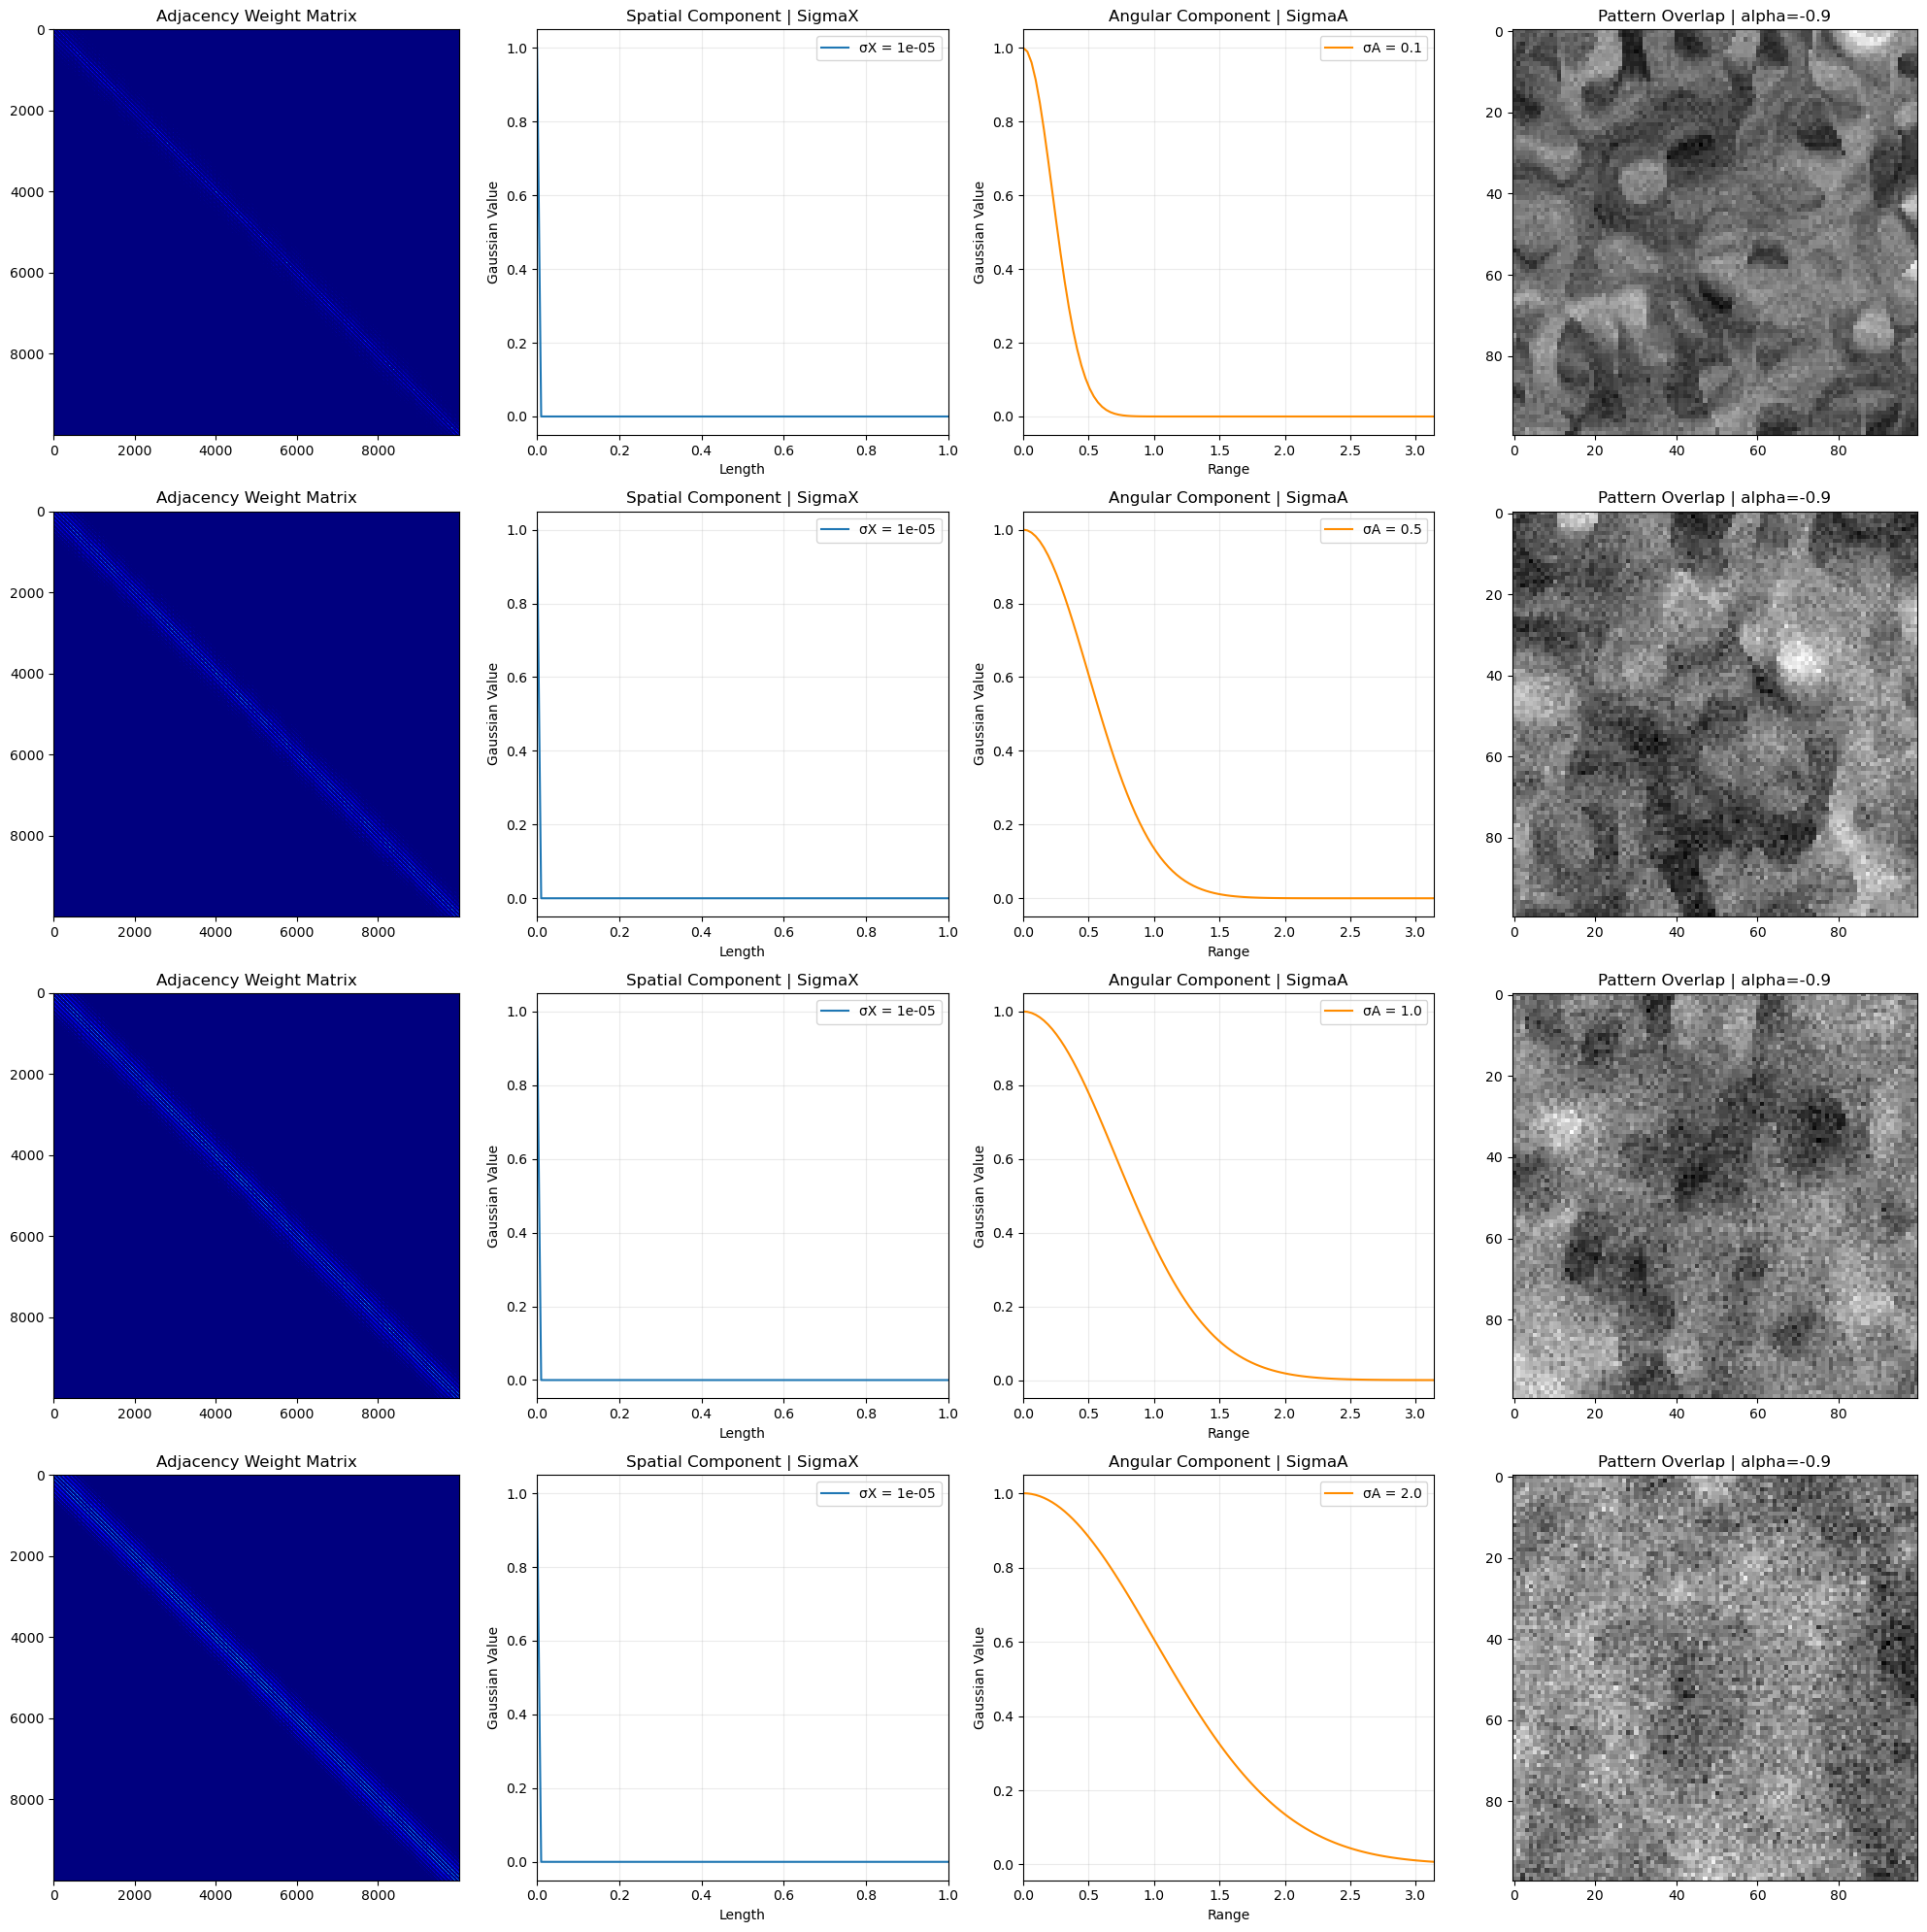

In [17]:
plt.figure(figsize=(20,20))
for i in range(ticker):
    plt.subplot(ticker, 4, i * 4 + 1)
    plt.imshow(Wa[i], 'jet')
    plt.title('Adjacency Weight Matrix')

    plt.subplot(ticker, 4, i * 4 + 2)
    dist_s = np.linspace(0, 1, 100)
    plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX), label=f'σX = {sigmaX}')
    plt.title('Spatial Component | SigmaX')
    plt.xlabel('Length'), plt.ylabel('Gaussian Value')
    plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 4, i * 4 + 3)
    dist_a = np.linspace(0, np.pi, 100)
    plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA[i]), 'darkorange', label=f'σA = {sigmaA[i]}')
    plt.title('Angular Component | SigmaA')
    plt.xlabel('Range'), plt.ylabel('Gaussian Value')
    plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 4, i * 4 + 4)
    plt.imshow(Ma[i].reshape(src.shape), 'gray')
    plt.title('Pattern Overlap | alpha=' + str(alpha))

plt.tight_layout()